In [2]:
import sys,os
import pandas as pd
import random
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns
import numpy as np
import sklearn
import string
import re
import nltk
import tensorflow as tf
from collections import Counter
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, classification_report, roc_curve
from datetime import datetime
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from google.colab import files,drive
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold,cross_val_score,cross_val_predict
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from enum import Enum
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
print(f"Running Panda Version: {pd.__version__}")
print(f"Running TensorFlow Version: {tf.__version__}")
print(f"Running Keras API Version:{keras.__version__}")
print(f"Running Python {sys.version_info[:2][0]}.{sys.version_info[:2][1]}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Running Panda Version: 2.2.2
Running TensorFlow Version: 2.19.0
Running Keras API Version:3.10.0
Running Python 3.12


In [3]:
seed = 0
tf.keras.utils.set_random_seed(seed)

In [4]:
uploaded = files.upload()
dataset = pd.read_csv("Tweets.csv",na_values=['NA'], low_memory=False)

Saving Tweets.csv to Tweets.csv


# EDA (Exploratory Data Analysis)

## Descriptive statistics

#### Shape of dataset

In [5]:
shapes = f"Dataset structure: rows: {dataset.shape[0]} - columns: {dataset.shape[1]}"
print(shapes)

Dataset structure: rows: 14640 - columns: 15


#### Radom samples

In [6]:
dataset.sample(4)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
13983,569682010270101504,negative,0.6163,Late Flight,0.6163,American,NaN,zsalim03,NaN,0,@AmericanAir In car gng to DFW. Pulled over 1h...,NaN,2015-02-22 18:15:50 -0800,Texas,Central Time (US & Canada)
14484,569608307184242688,negative,0.7039,Bad Flight,0.3587,American,NaN,sa_craig,NaN,0,"@AmericanAir after all, the plane didn’t land ...",NaN,2015-02-22 13:22:57 -0800,"College Station, TX",Central Time (US & Canada)
6403,567879304593408001,negative,1.0000,Cancelled Flight,1.0000,Southwest,NaN,DanaChristos,NaN,1,@SouthwestAir can't believe how many paying cu...,NaN,2015-02-17 18:52:31 -0800,CT,Eastern Time (US & Canada)
9653,569757651539660801,negative,1.0000,Can't Tell,1.0000,US Airways,NaN,rossj987,NaN,0,@USAirways I can legitimately say that I would...,NaN,2015-02-22 23:16:24 -0800,"Washington, D.C.",Eastern Time (US & Canada)


#### Dataset Features types

In [7]:
dataset.dtypes

,0
tweet_id,int64
airline_sentiment,object
airline_sentiment_confidence,float64
negativereason,object
negativereason_confidence,float64
airline,object
airline_sentiment_gold,object
name,object
negativereason_gold,object
retweet_count,int64


#### Names of columns

In [8]:
", ".join(dataset.columns.tolist())

'tweet_id, airline_sentiment, airline_sentiment_confidence, negativereason, negativereason_confidence, airline, airline_sentiment_gold, name, negativereason_gold, retweet_count, text, tweet_coord, tweet_created, tweet_location, user_timezone'

#### Categorical features

In [9]:
dataset.describe(include='O').T

,count,unique,top,freq
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_created,14640,14247,2015-02-24 09:54:34 -0800,5
tweet_location,9907,3081,"Boston, MA",157


#### Numeric features

In [10]:
dataset.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


#### Target classes

In [11]:
", ".join(dataset.airline_sentiment.unique().tolist())

'neutral, positive, negative'

In [12]:
dataset.airline_sentiment.value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


Imbalance data ( more negatives than positive and neutral)

#### Missing values and duplicates

In [13]:
print('Sum of Missing values accross columns\n',dataset.isnull().sum())
print('-'*40)
print("Sum of missing values",sum(dataset.isnull().sum()))

Sum of Missing values accross columns
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
----------------------------------------
Sum of missing values 61962


In [14]:
print('Sum of duplicated rows :',dataset.duplicated().sum())

Sum of duplicated rows : 36


### Airlines

In [15]:
names_of_airlines = dataset.airline.unique().tolist()
", ".join(names_of_airlines)

'Virgin America, United, Southwest, Delta, US Airways, American'

In [16]:
dataset.airline.value_counts()

,count
airline,
United,3822
US Airways,2913
American,2759
Southwest,2420
Delta,2222
Virgin America,504


#### Tweets

In [17]:
print("Tweets frequencies grouped by sentiments for the airlines")
print('-'*60)
airlines_sentiments_groups = dataset.groupby("airline", group_keys=True)[['airline_sentiment']].value_counts()
airlines_sentiments_groups

Tweets frequencies grouped by sentiments for the airlines
------------------------------------------------------------


airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: count, dtype: int64

In [18]:
print("Time of first tweet in the dataset:",dataset.tweet_created.min())
print('-'*65)
print("Time of last tweet in the dataset:",dataset.tweet_created.max())

Time of first tweet in the dataset: 2015-02-16 23:36:05 -0800
-----------------------------------------------------------------
Time of last tweet in the dataset: 2015-02-24 11:53:37 -0800


In [19]:
dataset[dataset['negativereason'] != 'N/A'].groupby("airline", group_keys=True)[['negativereason']].value_counts()

airline         negativereason             
American        Customer Service Issue         768
                Late Flight                    249
                Cancelled Flight               246
                Can't Tell                     198
                Lost Luggage                   149
                Flight Booking Problems        130
                Bad Flight                      87
                Flight Attendant Complaints     87
                longlines                       34
                Damaged Luggage                 12
Delta           Late Flight                    269
                Customer Service Issue         199
                Can't Tell                     186
                Bad Flight                      64
                Flight Attendant Complaints     60
                Lost Luggage                    57
                Cancelled Flight                51
                Flight Booking Problems         44
                longlines                       14
                Damaged Luggage                 11
Southwest       Customer Service Issue         391
                Cancelled Flight               162
                Can't Tell                     159
                Late Flight                    152
                Bad Flight                      90
                Lost Luggage                    90
                Flight Booking Problems         61
                Flight Attendant Complaints     38
                longlines                       29
                Damaged Luggage                 14
US Airways      Customer Service Issue         811
                Late Flight                    453
                Can't Tell                     246
                Cancelled Flight               189
                Lost Luggage                   154
                Flight Attendant Complaints    123
                Flight Booking Problems        122
                Bad Flight                     104
                longlines                       50
                Damaged Luggage                 11
United          Customer Service Issue         681
                Late Flight                    525
                Can't Tell                     379
                Lost Luggage                   269
                Bad Flight                     216
                Cancelled Flight               181
                Flight Attendant Complaints    168
                Flight Booking Problems        144
                longlines                       48
                Damaged Luggage                 22
Virgin America  Customer Service Issue          60
                Flight Booking Problems         28
                Can't Tell                      22
                Bad Flight                      19
                Cancelled Flight                18
                Late Flight                     17
                Flight Attendant Complaints      5
                Lost Luggage                     5
                Damaged Luggage                  4
                longlines                        3
Name: count, dtype: int64

#### Top tweet authors

In [20]:
top_tweeter = Counter([name for name in dataset['name']])
top_tweeter_df = pd.DataFrame(top_tweeter.most_common(10))
top_tweeter_df.columns = ['top_tweet_authors','count']
print("Top 10 Authors",'-'*15)
top_tweeter_df

Top 10 Authors ---------------


,top_tweet_authors,count
0,JetBlueNews,63
1,kbosspotter,32
2,_mhertz,29
3,otisday,28
4,throthra,27
5,rossj987,23
6,weezerandburnie,23
7,MeeestarCoke,22
8,GREATNESSEOA,22
9,scoobydoo9749,21


#### Two top authors

In [21]:
dataset[dataset['name'] == 'JetBlueNews'][['airline','negativereason','airline_sentiment','retweet_count']].value_counts()

,,,,count
airline,negativereason,airline_sentiment,retweet_count,
Delta,Can't Tell,negative,0,1


In [22]:
dataset[dataset['name'] == 'kbosspotter'][['airline','negativereason','airline_sentiment','retweet_count']].value_counts()

airline  negativereason           airline_sentiment  retweet_count
Delta    Cancelled Flight         negative           0                1
         Customer Service Issue   negative           0                1
         Flight Booking Problems  negative           0                1
         Late Flight              negative           0                1
Name: count, dtype: int64

#### Top reasons for complaints.

In [23]:
top_complain = Counter([reason for reason in dataset[dataset['negativereason'].notna()]['negativereason']])
top_complain_df = pd.DataFrame(top_complain.most_common(10))
top_complain_df.columns = ['top_complain_reason','count']
print("Top 10 complain",'-'*15)
top_complain_df

Top 10 complain ---------------


,top_complain_reason,count
0,Customer Service Issue,2910
1,Late Flight,1665
2,Can't Tell,1190
3,Cancelled Flight,847
4,Lost Luggage,724
5,Bad Flight,580
6,Flight Booking Problems,529
7,Flight Attendant Complaints,481
8,longlines,178
9,Damaged Luggage,74


In [24]:
dataset[['text','airline','name','airline_sentiment']].loc[dataset['retweet_count'].max()]

,44
text,@VirginAmerica are flights leaving Dallas for ...
airline,Virgin America
name,papamurat
airline_sentiment,neutral


## Multivariate analysis (Visualization).

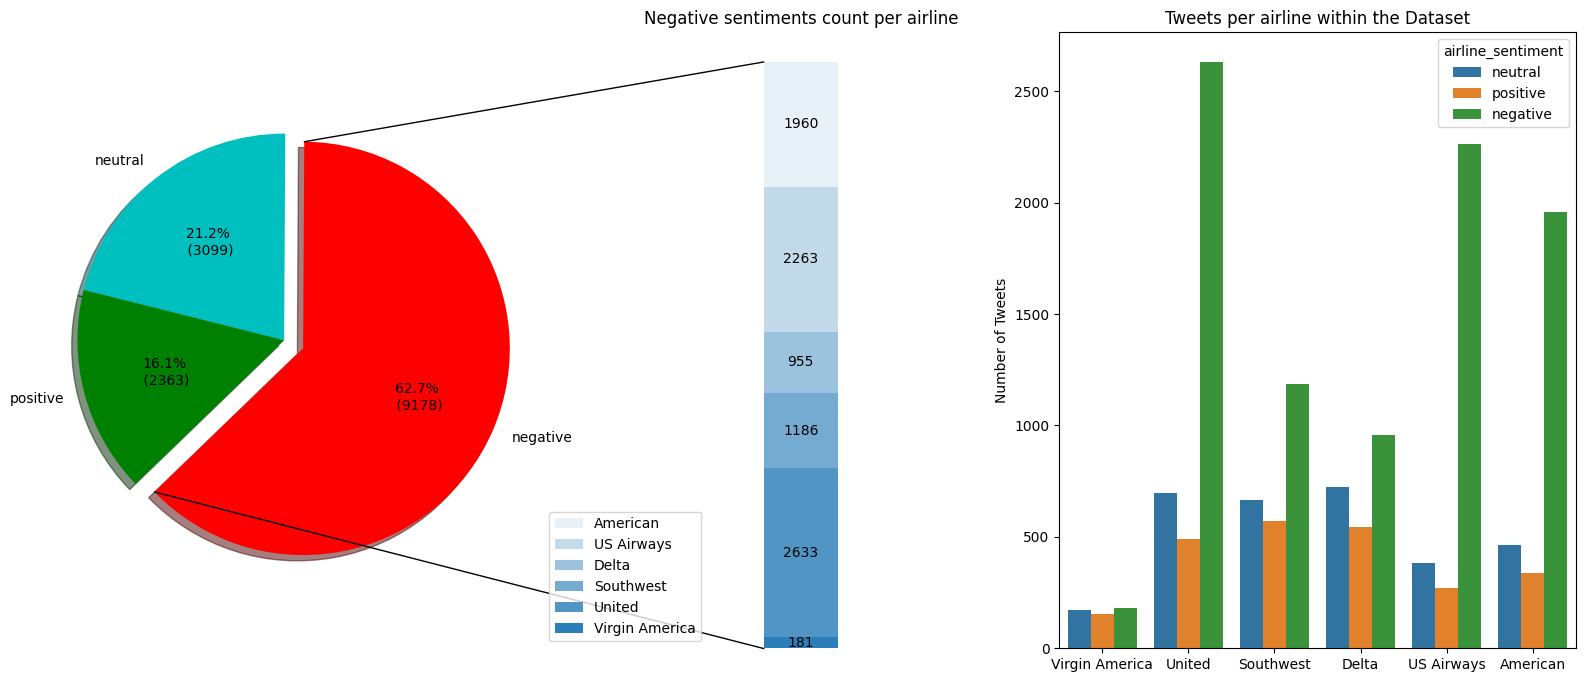

In [25]:
classes,tweet_freq = np.unique(dataset.airline_sentiment,return_counts=True)

def func(pct, allvals)->str:
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n ({absolute:d})"

# make figure and assign axis objects
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 8))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = tweet_freq
labels = classes
explode = [0.1, 0, 0]
colors =['r','c','g']
# rotate so that first wedge is split by the x-axis
angle = -272 * overall_ratios[2]
wedges, *_ = ax1.pie(overall_ratios, autopct=lambda pct: func(pct, overall_ratios),shadow=True,labels=labels, explode=explode,colors=colors,startangle=angle)

# bar chart parameters
negative_sentiment_ratios =[airlines_sentiments_groups[x]['negative'] for x in names_of_airlines]
bottom = 5
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(negative_sentiment_ratios, names_of_airlines)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,alpha=0.1 + 0.17 * j)
    ax2.bar_label(bc, labels=[height], label_type='center')

ax2.legend(loc=3)
ax2.set_title('Negative sentiments count per airline')
ax2.axis('off')
ax2.set_xlim(- 3.5 * width, 3.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(negative_sentiment_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, -bar_height), coordsA=ax2.transData,xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(1)

ax3 = sns.countplot(x="airline", hue="airline_sentiment", data=dataset)
ax3.set_xlabel('')
ax3.set_ylabel('Number of Tweets')
ax3.set_title('Tweets per airline within the Dataset')


plt.show()
del ax1,ax2,ax3

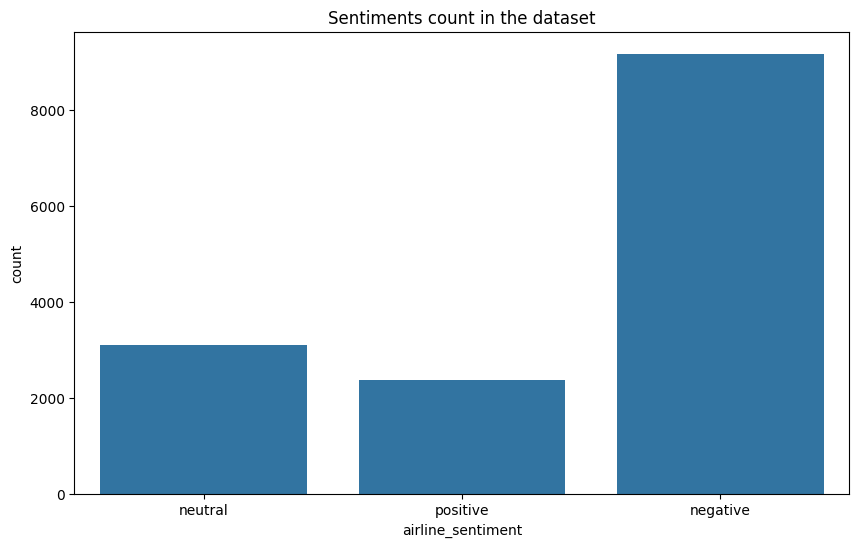

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='airline_sentiment', data=dataset, ax=ax)
ax.set_title('Sentiments count in the dataset')
plt.show()
del ax,fig

#### Decompose tweet time  

In [27]:
def decompose_date(date_str)-> pd.Series:
  aux = date_str.replace(' -0800','')
  date_utc = datetime.strptime(aux,"%Y-%m-%d %H:%M:%S")
  return pd.Series([date_utc.weekday(),date_utc.day,date_utc.hour])


dataset[['week_day','day','hour']] = dataset.pop('tweet_created').apply(decompose_date)

#### Daily tweet frequency

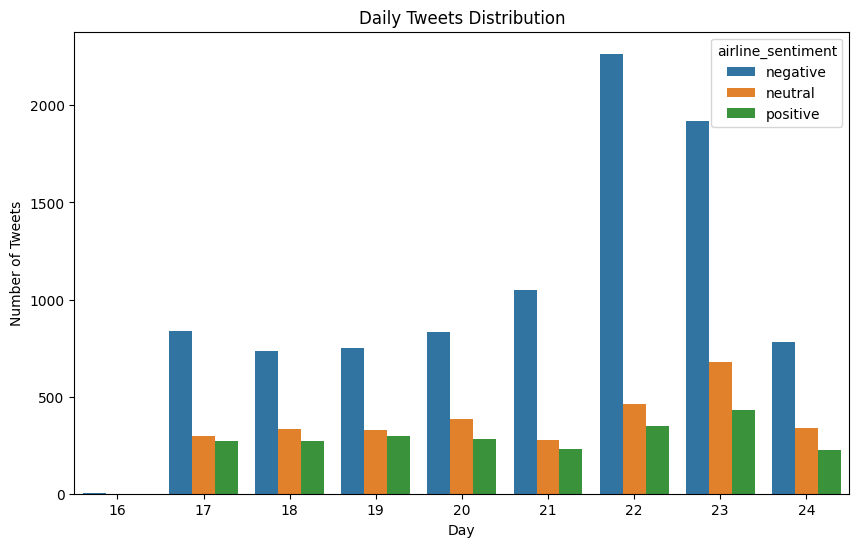

In [28]:
fig, axes = plt.subplots(figsize=(10,6))
ax = sns.countplot(x="day", hue="airline_sentiment", data=dataset)
ax.set_xlabel('Day')
ax.set_ylabel('Number of Tweets')
ax.set_title('Daily Tweets Distribution')
del ax,fig,axes

#### 24hrs tweet distribution

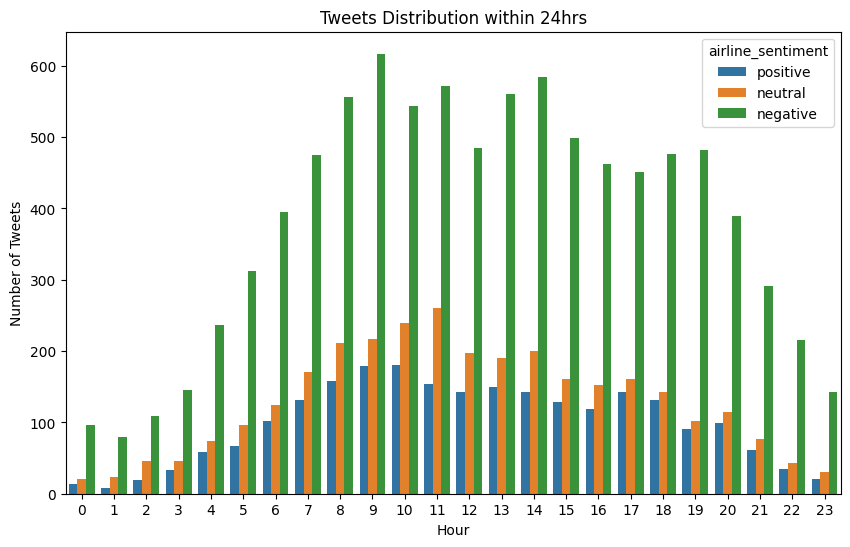

In [29]:
fig, axes = plt.subplots(figsize=(10,6))
ax = sns.countplot(x="hour", hue="airline_sentiment", data=dataset)
ax.set_xlabel('Hour')
ax.set_ylabel('Number of Tweets')
ax.set_title('Tweets Distribution within 24hrs')
del ax,fig,axes

#### Tweets in days of the week

/tmp/ipython-input-645423364.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])


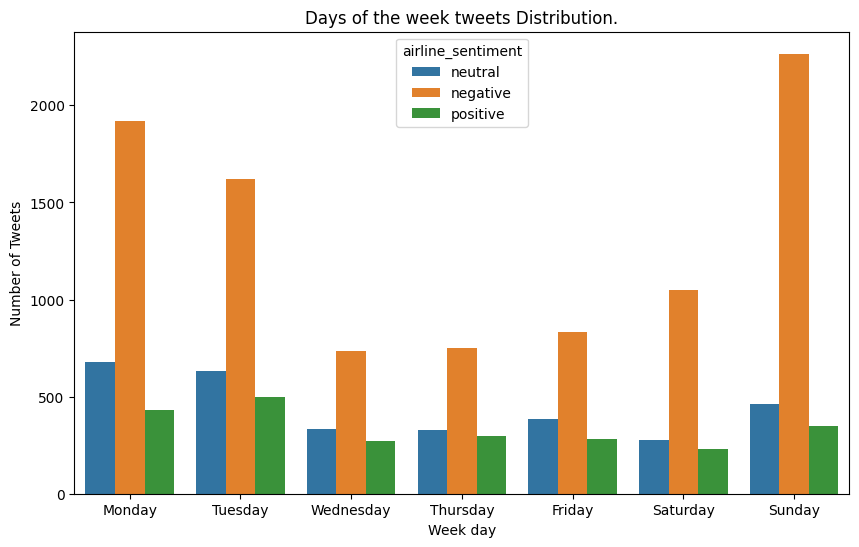

In [30]:
fig, axes = plt.subplots(figsize=(10,6))
ax = sns.countplot(x="week_day", hue="airline_sentiment", data=dataset)
ax.set_xlabel('Week day')
ax.set(xticklabels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set_ylabel('Number of Tweets')
ax.set_title('Days of the week tweets Distribution.')
del ax,fig,axes

#### Word Cloud

In [31]:
positive_sentiment = dataset[dataset.airline_sentiment == "positive"]
positive_text=positive_sentiment['text']
negative_sentiment = dataset[dataset.airline_sentiment == 'negative']
negative_text=negative_sentiment['text']
neutral_sentiment = dataset[dataset.airline_sentiment == 'neutral']
neutral_text=neutral_sentiment['text']
complain_text = top_complain_df['top_complain_reason']
top_authors = top_tweeter_df["top_tweet_authors"]
print('The Dataset contains :',negative_sentiment.shape[0],' negative tweets')
print('The Dataset contains :',positive_sentiment.shape[0],' positive tweets')

The Dataset contains : 9178  negative tweets
The Dataset contains : 2363  positive tweets


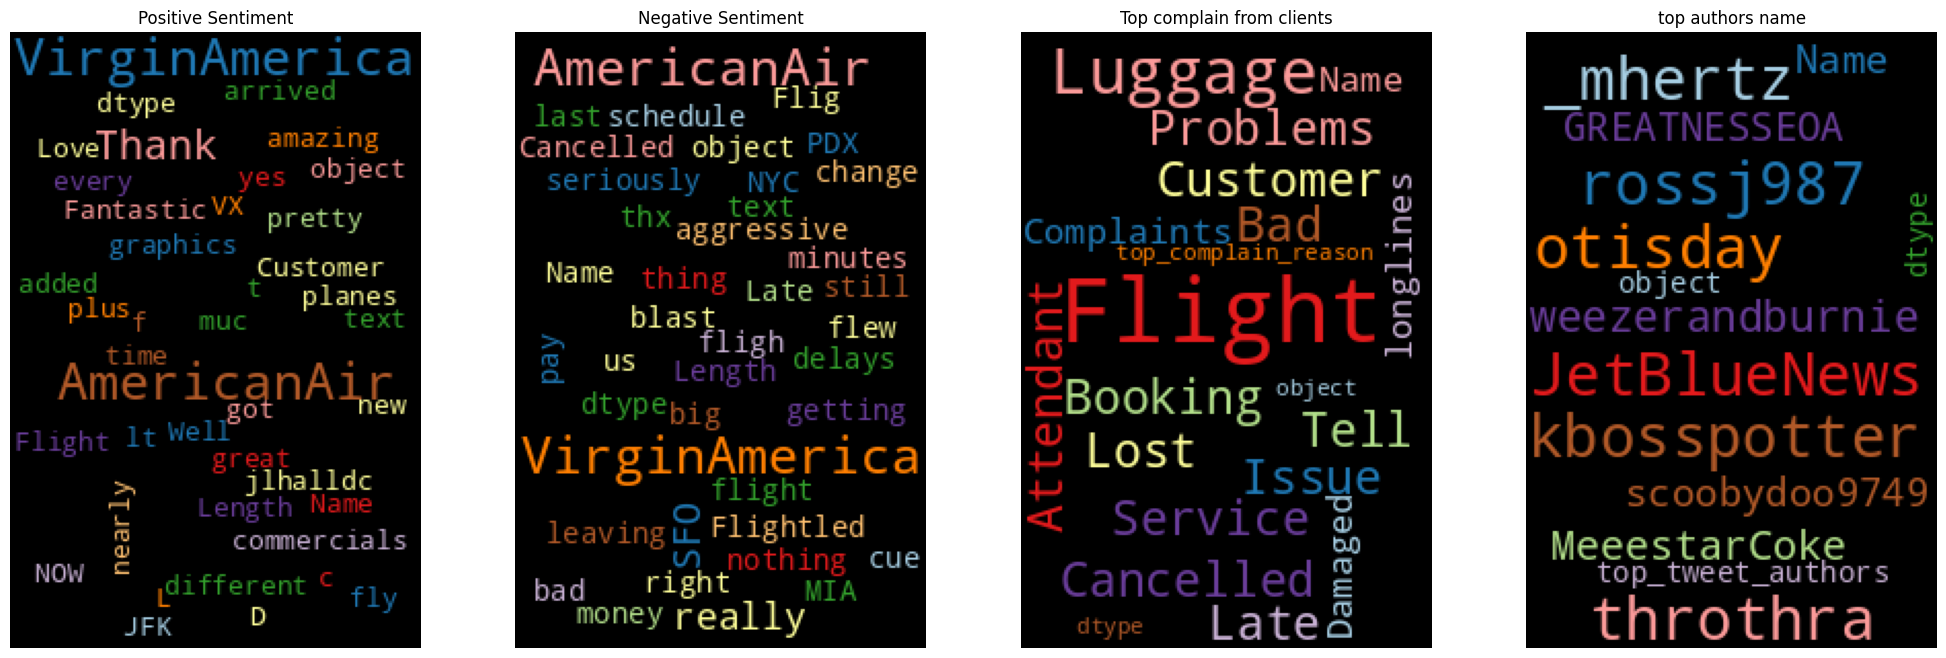

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(25, 8),edgecolor = 'k')
positive_tweet = WordCloud(width = 200,height = 300,colormap="Paired",background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(positive_text))
negative_tweet = WordCloud(width = 200,height = 300,colormap="Paired",background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(negative_text))
complain_tweet = WordCloud(width = 200,height = 300,colormap="Paired",background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(complain_text))
top_authors_tweet = WordCloud(width = 200,height = 300,colormap="Paired",background_color = 'black',max_words = 90,stopwords = STOPWORDS).generate(str(top_authors))

ax[0].imshow(positive_tweet)
ax[0].axis('off')
ax[0].set_title('Positive Sentiment')

ax[1].imshow(negative_tweet)
ax[1].axis('off')
ax[1].set_title('Negative Sentiment')


ax[2].imshow(complain_tweet)
ax[2].axis('off')
ax[2].set_title('Top complain from clients')


ax[3].imshow(top_authors_tweet)
ax[3].axis('off')
ax[3].set_title('top authors name')

plt.show()
del top_tweeter_df,top_complain_df,fig,ax,positive_tweet,negative_tweet,complain_tweet,top_authors_tweet

# Data preprocessing

#### Drop rows and columns that are not useful

In [33]:
dataset.drop(neutral_sentiment.index,inplace=True)

In [34]:
dataset.drop(['tweet_id','name','negativereason','negativereason_confidence','airline_sentiment_gold','negativereason_gold','tweet_coord','tweet_location','user_timezone'],axis=1,inplace=True)

In [35]:
dataset.head(3)

,airline_sentiment,airline_sentiment_confidence,airline,retweet_count,text,week_day,day,hour
1,positive,0.3486,Virgin America,0,@VirginAmerica plus you've added commercials t...,1,24,11
3,negative,1.0000,Virgin America,0,@VirginAmerica it's really aggressive to blast...,1,24,11
4,negative,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...,1,24,11


In [36]:
print('Number of categories: ',len(dataset.airline_sentiment.unique().tolist()))
print('Target categories: ',dataset.airline_sentiment.unique().tolist())
print("Sum of missing values",sum(dataset.isnull().sum()))

Number of categories:  2
Target categories:  ['positive', 'negative']
Sum of missing values 0


In [37]:
!pip install contractions
import contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.0 MB/s eta 0:00:00


##Feature engineering

In [38]:
def remove_url_from_text(tweet:str)->tuple[str,int]:
    url = re.compile(r'https?://\S+|www\.\S+')
    initial = len(tweet)
    text = url.sub(r'',tweet,re.IGNORECASE)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number+=1
    if( final == initial - number):
      return (result,0)
    else:
      return (result,1)

def remove_user_tags(tweet:str)->tuple[str,int]:
    user = re.compile(r'@\S+')
    initial = len(tweet)
    text = user.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number+=1
    if( final == initial - number):
      return [result,0]
    else:
      return [result,1]

def happy_emoji_removal(tweet:str) ->tuple[str,int]:
    happy = re.compile(r"([xX;:]-?[dDpP)])")
    initial = len(tweet)
    text = happy.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final != initial - number):
      return (result,1)
    return (result,0)

def sad_emoji_removal(tweet:str) -> tuple[str,int]:
    sad = re.compile(r"[:;](['\"]?[-~]?[/(\|C<>{}\[]+)")
    initial = len(tweet)
    text = sad.sub(r'',tweet)
    result = ''.join([i for i in text if not i.isdigit()])
    final = len(result)
    number = 0
    for i in text:
      if i.isdigit():
        number += 1
    if( final != initial - number):
      return (result,1)
    return (result,0)

def clean_and_create_feature(tweet:str)-> pd.Series:
  (text,user_flag) = remove_user_tags(tweet)
  (text,url_flag) = remove_url_from_text(text)
  (text,happy_flag) = happy_emoji_removal(text)
  (text,sad_flag) = sad_emoji_removal(text)
  text = contractions.fix(text)
  return pd.Series([text,user_flag,url_flag,happy_flag,sad_flag])

dataset[['text','user_flag','url_flag','happy_flag','sad_flag']] = dataset.text.apply(clean_and_create_feature)

In [39]:
dataset.head(3)

,airline_sentiment,airline_sentiment_confidence,airline,retweet_count,text,week_day,day,hour,user_flag,url_flag,happy_flag,sad_flag
1,positive,0.3486,Virgin America,0,plus you have added commercials to the eerien...,1,24,11,1,0,1,0
3,negative,1.0000,Virgin America,0,"it is really aggressive to blast obnoxious ""e...",1,24,11,1,0,0,0
4,negative,1.0000,Virgin America,0,and it is a really big bad thing about it,1,24,11,1,0,0,0


#### Stop word and punctuation removal and stemming

In [40]:
def stop_word_and_stemming(tweet:str)->str:
    tknzr = TweetTokenizer(preserve_case=False,strip_handles=True, reduce_len=True)
    myStemmer = PorterStemmer()
    tweets = tknzr.tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    # filter out stop words and filter out short tokens
    tokens = [myStemmer.stem(word) for word in tweets if word not in stop_words and len(word) > 1]
    tweet = ' '.join(tokens)
    return tweet

def remove_punctuations(text:str)->str:
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
dataset['text'] = dataset['text'].apply(stop_word_and_stemming)
dataset['text'] = dataset['text'].apply(remove_punctuations)

#### Target Encoding, $y_{i}$ can take values between  ${0}$ to  ${N-1}$

In [41]:
target_dict = {'positive':1,'negative': 0}
print(target_dict)
dataset['target'] = dataset['airline_sentiment'].map(target_dict)
del target_dict

{'positive': 1, 'negative': 0}


In [42]:
dataset.head(3)

,airline_sentiment,airline_sentiment_confidence,airline,retweet_count,text,week_day,day,hour,user_flag,url_flag,happy_flag,sad_flag,target
1,positive,0.3486,Virgin America,0,plu ad commerci eerienc tacki,1,24,11,1,0,1,0,1
3,negative,1.0000,Virgin America,0,realli aggress blast obnoxi entertain guest fa...,1,24,11,1,0,0,0,0
4,negative,1.0000,Virgin America,0,realli big bad thing,1,24,11,1,0,0,0,0


#### Split Dataset

In [43]:
def split_data(dataframe:pd.DataFrame,test_percentage:float)-> tuple[pd.DataFrame,pd.DataFrame]:
  permuted_range = np.random.permutation(len(dataframe))
  test_size = int(len(dataframe) * test_percentage)
  test_set = permuted_range[:test_size]
  train_set = permuted_range[test_size:]
  return (dataframe.iloc[train_set],dataframe.iloc[test_set])


In [44]:
Train, Test = split_data(dataset,0.2)
print(f"train shape: {Train.shape} - test shape: {Test.shape}")

train shape: (9233, 13) - test shape: (2308, 13)


In [45]:
Train.drop_duplicates(inplace=True)
print(f"train shape: {Train.shape} - test shape: {Test.shape}")

train shape: (9186, 13) - test shape: (2308, 13)


### Imbalance data

In [46]:
print(Train[['target','airline_sentiment']].value_counts())
print("test samples",'-'*20)
print(Test[['target','airline_sentiment']].value_counts())

target  airline_sentiment
0       negative             7295
1       positive             1891
Name: count, dtype: int64
test samples --------------------
target  airline_sentiment
0       negative             1845
1       positive              463
Name: count, dtype: int64


In [47]:
y_train = Train['target'].to_numpy()
y_test = Test['target'].to_numpy()

### *Bag-of-Words (BoW)*

TF-IDF is a simple calculation based on the frequency of a word in the document. It is weighted by the rarity of the word between all the documents available.

In [48]:
tfidf_vect = TfidfVectorizer().fit(Train['text'])

In [49]:
X_train = tfidf_vect.transform(Train['text'])
X_test = tfidf_vect.transform(Test['text'])

In [50]:
print(X_train.shape, y_train.shape)

(9186, 6945) (9186,)


### Baseline Model

In [51]:
def score_board_dataframe(y_test,predictions,model_name)-> pd.DataFrame:
  f1 = "%0.3f" % f1_score(y_test, predictions)
  prec = "%0.3f" % precision_score(y_test, predictions)
  rec ="%0.3f" % recall_score(y_test, predictions)
  acc = "%0.3f" % accuracy_score(y_test, predictions)
  return pd.DataFrame({"classifier-name":model_name,"f1_score":[f1],"precision":[prec],"recall":[rec],"accuracy":[acc]})

In [52]:
cross_val = StratifiedKFold(n_splits=5)
model = tree.DecisionTreeClassifier(class_weight="balanced")
scores = cross_val_score(model,X_train,y_train,scoring='accuracy',cv=cross_val,n_jobs=-1)
baseline_pred = cross_val_predict(model,X_train,y_train,cv=cross_val)
print('Baseline model performance:')
print('Mean Accuracy: ', np.mean(scores))

Baseline model performance:
Mean Accuracy:  0.8414991562033712


In [53]:
def calculate_conf_matrix(y_true, y_pred,threshold=0.5)-> pd.DataFrame:
    # Creating a confusion matrix
    cm = confusion_matrix(y_true, y_pred > threshold)
    con_mat = pd.DataFrame(cm, index=np.unique(y_true),columns=np.unique(y_true))
    #Ploting the confusion matrix
    plt.figure(figsize=(10,6))
    ax = sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap=plt.cm.Blues, cbar=False)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('\nPredicted labels')
    ax.set_ylabel('True labels')
    plt.show()
    del ax
    return con_mat,cm

In [54]:
score_board = score_board_dataframe(y_train, baseline_pred,"Decision Tree Baseline")
score_board

,classifier-name,f1_score,precision,recall,accuracy
0,Decision Tree Baseline,0.643,0.595,0.699,0.840


# Neural net

## *Word Embedding*

In [55]:
nn_df = dataset.copy()

In [56]:
unique_words = set(word.lower() for phrase in  nn_df['text'].to_numpy() for word in phrase.split(" "))

In [57]:
vocab_size = len(unique_words) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 7756


In [58]:
train_nn, test_nn = split_data(nn_df,0.3)

In [59]:
test_nn, val_nn = split_data(test_nn,0.5)

In [60]:
train_nn.drop_duplicates(inplace=True)
print(f"train shape: {train_nn.shape} - test shape: {test_nn.shape} - val shape: {val_nn.shape}")

train shape: (8042, 13) - test shape: (1731, 13) - val shape: (1731, 13)


In [61]:
train_labels = train_nn["target"].to_numpy()
test_labels = test_nn["target"].to_numpy()
val_labels = val_nn["target"].to_numpy()

In [62]:
counter = Counter(train_labels)
for k,v in counter.items():
	per = v / len(train_labels) * 100
	print('Class = %d, n = %d (%.3f%%)' % (k, v, per))

Class = 0, n = 6416 (79.781%)
Class = 1, n = 1626 (20.219%)


In [63]:
max_length = max([len(s.split()) for s in train_nn.text])

In [64]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_nn['text'])

In [65]:
def create_tweet_sequence(txt,toke_nizer,max_len):
  text_sequences = toke_nizer.texts_to_sequences(txt)
  return pad_sequences(text_sequences, maxlen=max_len,padding='post')


In [66]:
train_text = create_tweet_sequence(train_nn['text'], tokenizer, max_length)
test_text = create_tweet_sequence(test_nn['text'], tokenizer, max_length)
val_text = create_tweet_sequence(val_nn['text'], tokenizer, max_length)

In [67]:
 METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'),keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall'),keras.metrics.AUC(name='prc', curve='PR')]

 Output layer bias $b_0 = log_e(pos/neg)$

In [68]:
neg, pos = np.bincount(train_labels)
print(neg,pos)
initial_bias = np.log(pos/neg)
print(initial_bias)
output_bias = tf.keras.initializers.Constant(initial_bias)

6416 1626
-1.3726718594385945


In [69]:
embedding_vector_length = 32

In [70]:
model_1 = keras.models.Sequential()
model_1.add(keras.layers.Embedding(vocab_size, embedding_vector_length,input_length=max_length))
model_1.add(keras.layers.Bidirectional(keras.layers.LSTM(25,return_sequences=True)))
model_1.add(keras.layers.GlobalAveragePooling1D())
model_1.add(keras.layers.Dense(6, activation='relu'))
model_1.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
model_1.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=METRICS)
model_1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
EPOCHS = 10

In [72]:
lr = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.1, min_lr = 0.005, monitor='val_prc')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc',mode='max',patience=5,restore_best_weights=True,verbose=1)
model_1_history  = model_1.fit(train_text,train_labels,epochs=EPOCHS,callbacks=[lr,early_stopping],validation_data=(val_text ,val_labels),verbose=1)

Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8324 - loss: 0.4110 - prc: 0.5419 - precision: 0.5635 - recall: 0.2692 - val_accuracy: 0.9058 - val_loss: 0.2399 - val_prc: 0.8636 - val_precision: 0.7966 - val_recall: 0.7560 - learning_rate: 0.0010
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9308 - loss: 0.1866 - prc: 0.9015 - precision: 0.8422 - recall: 0.8032 - val_accuracy: 0.9145 - val_loss: 0.2289 - val_prc: 0.8753 - val_precision: 0.8205 - val_recall: 0.7721 - learning_rate: 0.0010
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9552 - loss: 0.1246 - prc: 0.9496 - precision: 0.8898 - recall: 0.8850 - val_accuracy: 0.9070 - val_loss: 0.2504 - val_prc: 0.8694 - val_precision: 0.7994 - val_recall: 0.7587 - learning_rate: 0.0010
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9732 - loss: 0.0884 - prc: 0.9681 - precision: 0.9434 - recall: 0.9210 - val_accuracy: 0.9012 - val_loss: 0.2953 - val_prc: 0.8515 -

In [73]:
model_1_results = model_1.evaluate(test_text ,test_labels,verbose=0)

In [74]:
for name, value in zip(model_1.metrics_names, model_1_results):
  print(name, ': {:.3f}'.format(value))
print()

loss : 0.207
compile_metrics : 0.918



In [75]:
model_1_predictions = model_1.predict(test_text)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [76]:
model_1_predicted_classes = np.where(model_1_predictions > 0.5, 1,0)

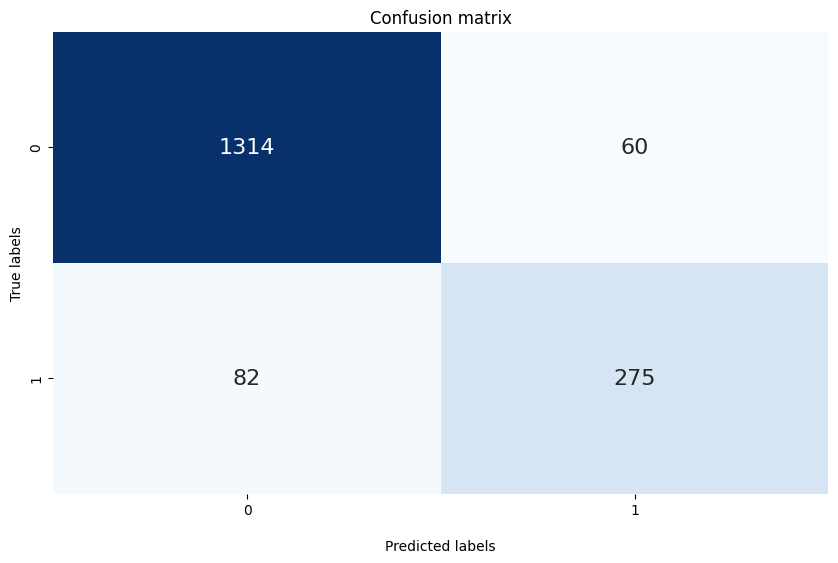

In [77]:
_,cm = calculate_conf_matrix(test_labels, model_1_predictions)

In [78]:
print('True Negatives: ', cm[0][0])
print('False Positives: ', cm[0][1])
print('False Negatives: ', cm[1][0])
print('True Positives: ', cm[1][1])

True Negatives:  1314
False Positives:  60
False Negatives:  82
True Positives:  275


In [79]:
score_board_1 = score_board_dataframe(test_labels, model_1_predicted_classes,"RNN")
score_board = pd.concat([score_board,score_board_1],ignore_index=True, sort=False)
score_board

,classifier-name,f1_score,precision,recall,accuracy
0,Decision Tree Baseline,0.643,0.595,0.699,0.840
1,RNN,0.795,0.821,0.770,0.918


### Pre-Trained GloVe Embedding

In [80]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-10-13 20:48:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-13 20:48:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-13 20:48:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [81]:
EMBEDDING_DIM = 100

In [82]:
embeddings_index = {}
glove_file = open('glove.6B.100d.txt')

In [83]:
for line in glove_file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
glove_file.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [84]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        embedding_matrix[i] = embedding_vector

In [85]:
embedding_layer = keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],weights=[embedding_matrix],input_length=max_length)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [86]:
model_2 = keras.models.Sequential()
model_2.add(embedding_layer)
model_2.add(keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)))
model_2.add(keras.layers.GlobalMaxPool1D())
model_2.add(keras.layers.Dense(16, activation='relu'))
model_2.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
print(model_2.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       775,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,600 (2.96 MB)

 Trainable params: 775,600 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

None


In [87]:
model_2.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=METRICS)

In [88]:
lr = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.1, min_lr = 0.01, monitor='val_prc')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc',mode='max',patience=5,restore_best_weights=True,verbose=1)
model_2_history  = model_2.fit(train_text,train_labels,epochs=EPOCHS,callbacks=[lr,early_stopping],validation_data=(val_text ,val_labels),verbose=1)

Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.8771 - loss: 0.3599 - prc: 0.7633 - precision: 0.7982 - recall: 0.5268 - val_accuracy: 0.9116 - val_loss: 0.2289 - val_prc: 0.8758 - val_precision: 0.8293 - val_recall: 0.7426 - learning_rate: 0.0010
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9153 - loss: 0.2097 - prc: 0.8672 - precision: 0.8306 - recall: 0.7227 - val_accuracy: 0.9168 - val_loss: 0.2100 - val_prc: 0.8889 - val_precision: 0.8300 - val_recall: 0.7721 - learning_rate: 0.0010
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9477 - loss: 0.1457 - prc: 0.9288 - precision: 0.9001 - recall: 0.8301 - val_accuracy: 0.9128 - val_loss: 0.2220 - val_prc: 0.8781 - val_precision: 0.7846 - val_recall: 0.8204 - learning_rate: 0.0010
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9675 - loss: 0.0996 - prc: 0.9616 - precision: 0.9364 - recall: 0.8984 - val_accuracy: 0.9064 - val_loss: 0.2692 - val_prc: 0.8624 

In [89]:
model_2_results = model_2.evaluate(test_text ,test_labels,verbose=0)

In [90]:
for name, value in zip(model_2.metrics_names, model_2_results):
  print(name, ': {:.3f}'.format(value))
print()

loss : 0.209
compile_metrics : 0.910



In [91]:
model_2_predictions = model_2.predict(test_text)
model_2_predicted_classes = np.where(model_2_predictions > 0.5, 1,0)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


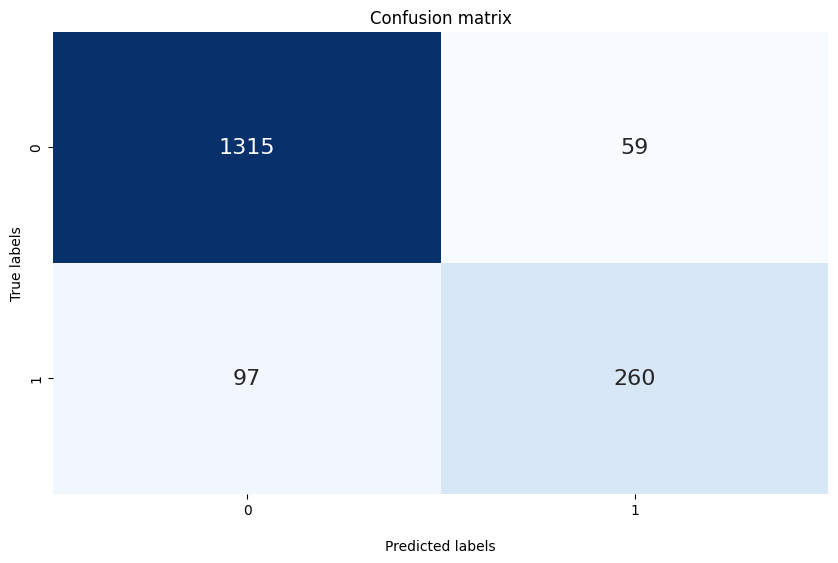

In [92]:
_,cm = calculate_conf_matrix(test_labels, model_2_predictions)

In [93]:
score_board_2 = score_board_dataframe(test_labels, model_2_predicted_classes,"RNN + GloVe")
score_board = pd.concat([score_board,score_board_2],ignore_index=True, sort=False)
score_board

,classifier-name,f1_score,precision,recall,accuracy
0,Decision Tree Baseline,0.643,0.595,0.699,0.840
1,RNN,0.795,0.821,0.770,0.918
2,RNN + GloVe,0.769,0.815,0.728,0.910


In [94]:
other_features_train = train_nn.drop(['target','text','airline_sentiment','retweet_count','airline_sentiment_confidence','airline'],inplace=False,axis=1)

In [95]:
other_features_test = test_nn.drop(['target','text','retweet_count','airline_sentiment','airline_sentiment_confidence','airline'],inplace=False,axis=1)

In [96]:
other_features_val = val_nn.drop(['target','text','retweet_count','airline_sentiment','airline_sentiment_confidence','airline'],inplace=False,axis=1)

In [97]:
other_features_train.head(1)

,week_day,day,hour,user_flag,url_flag,happy_flag,sad_flag
7697,5,21,19,1,0,0,0


In [98]:
scaler = StandardScaler()

In [99]:
other_features_train = scaler.fit_transform(other_features_train)
other_features_test = scaler.transform(other_features_test)
other_features_val = scaler.transform(other_features_val)

In [100]:
print(train_text.shape,other_features_train.shape)

(8042, 20) (8042, 7)


In [101]:
input_dense = keras.layers.Input(shape=(7,),name='input_a')
input_embedding = keras.layers.Input(shape=(max_length,),name='input_b')
embedding = keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],weights=[embedding_matrix])(input_embedding)
lstm = keras.layers.LSTM(100)(embedding)
merged = keras.layers.Concatenate(axis=-1)([lstm,input_dense])
Dense_1 = keras.layers.Dense(32,activation='relu')(merged)
Dropout =keras.layers.Dropout(0.5)(Dense_1)
Output = keras.layers.Dense(1,activation='sigmoid',bias_initializer=output_bias)(Dropout)
model_3 = keras.Model(inputs=[input_embedding, input_dense], outputs=[Output])
print(model_3.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_b             │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 20, 100)   │    775,600 │ input_b[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 100)       │     80,400 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_a             │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 107)       │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ input_a[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      3,456 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 859,489 (3.28 MB)

 Trainable params: 859,489 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [102]:
model_3.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=METRICS)

In [103]:
model_3_history = model_3.fit(x=[train_text,other_features_train],y=train_labels,epochs=EPOCHS,validation_data=([val_text,other_features_val], val_labels), callbacks=[lr,early_stopping],verbose=1)

Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8686 - loss: 0.3892 - prc: 0.7271 - precision: 0.7678 - recall: 0.5039 - val_accuracy: 0.9070 - val_loss: 0.2189 - val_prc: 0.8760 - val_precision: 0.8397 - val_recall: 0.7024 - learning_rate: 0.0010
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9056 - loss: 0.2288 - prc: 0.8385 - precision: 0.8177 - recall: 0.6773 - val_accuracy: 0.9093 - val_loss: 0.2256 - val_prc: 0.8813 - val_precision: 0.7727 - val_recall: 0.8204 - learning_rate: 0.0010
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9404 - loss: 0.1665 - prc: 0.9078 - precision: 0.8829 - recall: 0.8090 - val_accuracy: 0.9116 - val_loss: 0.2197 - val_prc: 0.8798 - val_precision: 0.8716 - val_recall: 0.6917 - learning_rate: 0.0010
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9550 - loss: 0.1283 - prc: 0.9401 - precision: 0.9088 - recall: 0.8614 - val_accuracy: 0.9053 - val_loss: 0.2529 - val_prc: 0.8654 -

In [104]:
model_3_results = model_3.evaluate([test_text,other_features_test] ,test_labels,verbose=0)

In [105]:
for name, value in zip(model_3.metrics_names, model_3_results):
  print(name, ': {:.3f}'.format(value))
print()

loss : 0.235
compile_metrics : 0.902



In [106]:
model_3_predictions = model_3.predict([test_text,other_features_test])
model_3_predicted_classes = np.where(model_3_predictions > 0.5, 1,0)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


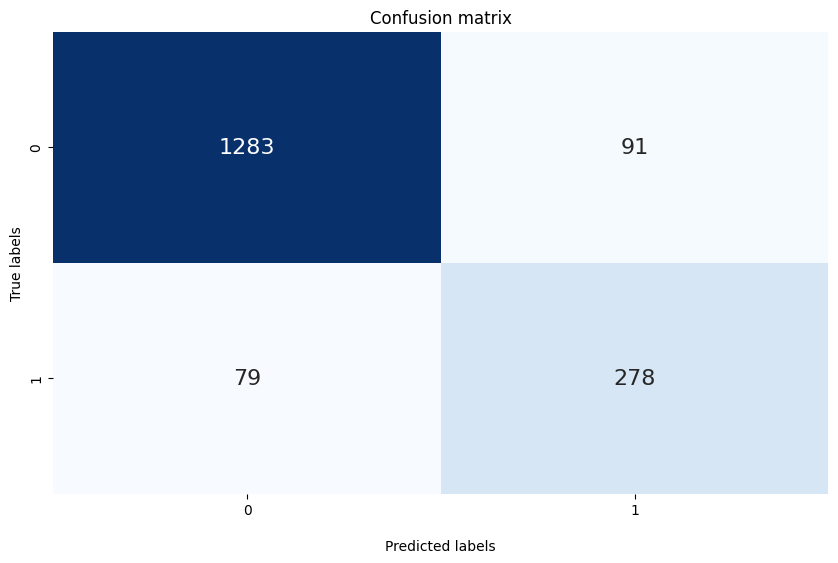

In [107]:
_,cm = calculate_conf_matrix(test_labels, model_3_predictions)

In [108]:
score_board_3 = score_board_dataframe(test_labels, model_3_predicted_classes,"RNN + GloVe + Xtra features")
score_board = pd.concat([score_board,score_board_3],ignore_index=True, sort=False)
score_board

,classifier-name,f1_score,precision,recall,accuracy
0,Decision Tree Baseline,0.643,0.595,0.699,0.840
1,RNN,0.795,0.821,0.770,0.918
2,RNN + GloVe,0.769,0.815,0.728,0.910
3,RNN + GloVe + Xtra features,0.766,0.753,0.779,0.902


In [109]:
input_dense = keras.layers.Input(shape=(7,),name='input_a')
input_embedding = keras.layers.Input(shape=(max_length,),name='input_b')
embedding = keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],weights=[embedding_matrix])(input_embedding)
conv_1 = keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu',bias_initializer=output_bias)(embedding)
max_pol = keras.layers.MaxPooling1D(pool_size=2)(conv_1)
flatten = keras.layers.Flatten()(max_pol)
merged = keras.layers.Concatenate(axis=-1)([flatten,input_dense])
Output = keras.layers.Dense(1,activation='sigmoid',bias_initializer=output_bias)(merged)
model_4 = keras.Model(inputs=[input_embedding, input_dense], outputs=[Output])
print(model_4.summary())
model_4.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=METRICS)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_b             │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 20, 100)   │    775,600 │ input_b[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 16, 128)   │     64,128 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 8, 128)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_a             │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1031)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ input_a[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │      1,032 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 840,760 (3.21 MB)

 Trainable params: 840,760 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

None


In [110]:
model_4_history = model_4.fit(x=[train_text,other_features_train],y=train_labels,epochs=EPOCHS,validation_data=([val_text,other_features_val], val_labels), callbacks=[lr,early_stopping],verbose=1)

Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8448 - loss: 0.4579 - prc: 0.6253 - precision: 0.7642 - recall: 0.3404 - val_accuracy: 0.8949 - val_loss: 0.2670 - val_prc: 0.8217 - val_precision: 0.8282 - val_recall: 0.6461 - learning_rate: 0.0010
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8940 - loss: 0.2473 - prc: 0.8142 - precision: 0.8148 - recall: 0.6063 - val_accuracy: 0.9064 - val_loss: 0.2311 - val_prc: 0.8619 - val_precision: 0.8207 - val_recall: 0.7239 - learning_rate: 0.0010
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9371 - loss: 0.1677 - prc: 0.9128 - precision: 0.8887 - recall: 0.7827 - val_accuracy: 0.9116 - val_loss: 0.2287 - val_prc: 0.8673 - val_precision: 0.8143 - val_recall: 0.7641 - learning_rate: 0.0010
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9658 - loss: 0.1087 - prc: 0.9613 - precision: 0.9361 - recall: 0.8893 - val_accuracy: 0.9122 - val_loss: 0.2479 - val_prc: 0.8597 -

In [111]:
model_4_results = model_4.evaluate([test_text,other_features_test] ,test_labels,verbose=0)

In [112]:
for name, value in zip(model_4.metrics_names, model_4_results):
  print(name, ': {:.3f}'.format(value))
print()

loss : 0.206
compile_metrics : 0.915



In [113]:
model_4_predictions = model_4.predict([test_text,other_features_test])
model_4_predicted_classes = np.where(model_4_predictions > 0.5, 1,0)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


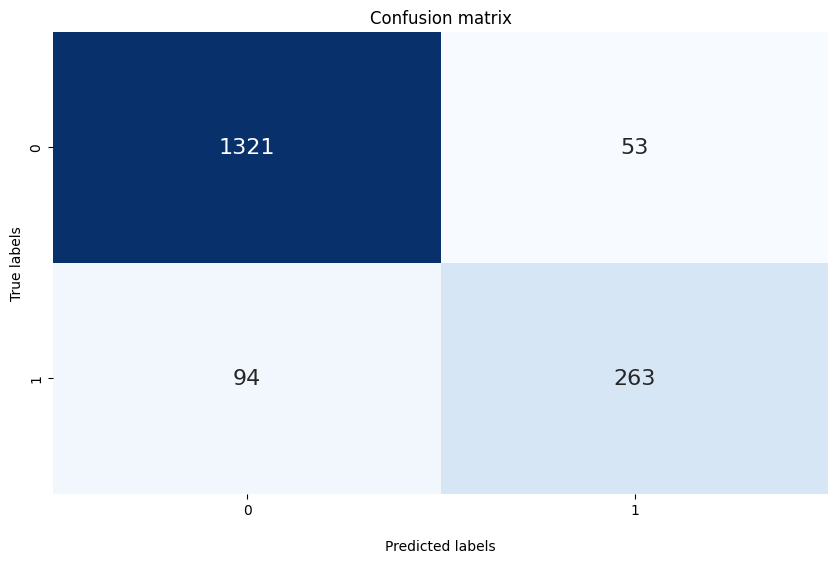

In [114]:
_,cm = calculate_conf_matrix(test_labels, model_4_predictions)

In [115]:
score_board_4 = score_board_dataframe(test_labels, model_4_predicted_classes,"CNN + GloVe + Xtra features")
score_board = pd.concat([score_board,score_board_4],ignore_index=True, sort=False)
score_board

,classifier-name,f1_score,precision,recall,accuracy
0,Decision Tree Baseline,0.643,0.595,0.699,0.840
1,RNN,0.795,0.821,0.770,0.918
2,RNN + GloVe,0.769,0.815,0.728,0.910
3,RNN + GloVe + Xtra features,0.766,0.753,0.779,0.902
4,CNN + GloVe + Xtra features,0.782,0.832,0.737,0.915


## *Experiments*

In [137]:
class ACTIVATION(str, Enum):
    SIGMOID = "0"
    TAN_H = "1"
    RELU = "2"
    LEAKY_RELU = "3"
    SOFTMAX = "4"


class NeuralNet:
    def __init__(
        self,
        no_inputs: int,
        no_hidden_layers: int = 1,
        hidden_layer_size: int = 28,
        output_size: int = 1,
        max_iterations: int = 20,
        learning_rate: float = 0.01,
    ):
        self.no_inputs = no_inputs
        self.output_size = output_size
        self.no_hidden_layers = no_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
        prev_nodes = self.no_inputs
        self.hidden_weights = []
        self.layer_output = []
        self.hidden_gradients = []
        self.output_gradient = 0.0
        self.output_error = 0.0
        for _ in range(self.no_hidden_layers):
            self.hidden_weights.append(
                self.get_random_weights((self.hidden_layer_size, prev_nodes))
            )
            prev_nodes = hidden_layer_size + 1
        self.output_weights = self.get_random_weights((self.output_size, prev_nodes))



    # =======================================#
    # Prints the details of the neural net.  #
    # =======================================#
    def print_details(self):
        print(f"No. inputs:\t {self.no_inputs}")
        print(f"Max iterations:\t {self.max_iterations}")
        print(f"Learning rate:\t {self.learning_rate}")



    def get_random_weights(self, size: tuple) -> np.ndarray:
        return np.array(np.random.rand(size[0], size[1]), dtype=np.float64)



    def act_fn(
        self,
        x: np.array,
        activation_type: ACTIVATION,
        derivative: bool = False,
    ):
        match activation_type:
            case ACTIVATION.SIGMOID:
                sgm = 1 / (1 + np.exp(-x))
                return (sgm * (1 - sgm)) if derivative else sgm
            case ACTIVATION.TAN_H:
                tanh = np.tanh(x)
                return (1 - tanh**2) if derivative else tanh
            case ACTIVATION.RELU:
                return (
                    np.where(x > 0, 1, 0)
                    if derivative
                    else np.maximum(
                        0,
                        x,
                    )
                )
            case ACTIVATION.LEAKY_RELU:
                alpha = 0.01
                return (
                    np.where(x > 0, 1, alpha)
                    if derivative
                    else np.where(x > 0, x, alpha * x)
                )
            case ACTIVATION.SOFTMAX:
                exps = np.exp(x - np.max(x))
                return exps / np.sum(exps)



    def train(self, training_data, training_labels):
        assert len(training_data) == len(training_labels)
        both = list(zip(training_data, training_labels))
        for i in range(self.max_iterations):
            random.shuffle(both)
            for data, label in both:
                self.feed_forward(data, label)
                self.back_propagation(data)
                self.update_weights()



    def evaluate(self, testing_data, test_labels)-> np.array:
        assert len(testing_data) == len(test_labels)
        (
            true_positive,
            false_negative,
            false_positive,
            true_negative,
            accuracy,
            precision,
            recall,
        ) = (
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
        )
        predictions = []
        for data, label in zip(testing_data, test_labels):
            prediction = self.predict(data)
            if label and prediction > 0.5:
                true_positive += 1
            elif not label and prediction < 0.5:
                true_negative += 1
            elif not label and prediction > 0.5:
                false_positive += 1
            elif label and prediction < 0.5:
                false_negative += 1
            predictions.append(prediction)
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        accuracy = (true_positive + true_negative) / (
            true_negative + true_positive + false_positive + false_negative
        )
        print(f"Accuracy: {np.round(accuracy, 2)}")
        print(f"Precision: {np.round(precision, 2)}")
        print(f"Recall: {np.round(recall, 2)}")
        return np.array(predictions, dtype='float32')

    def predict(self, data):
        initial_output = data
        layer_output = []
        for i in range(self.no_hidden_layers):
            dot_product = np.dot(initial_output, self.hidden_weights[i].T)
            layer_output.append(
                np.hstack((np.ones((1)), self.act_fn(dot_product, ACTIVATION.RELU)))
            )
            initial_output = layer_output[i]
        return self.act_fn(
            np.dot(initial_output, self.output_weights.T), ACTIVATION.SIGMOID
        )


    def feed_forward(self, data, label):
        last_output = data
        self.layer_output = []
        for i in range(self.no_hidden_layers):
            dot_product = np.dot(last_output, self.hidden_weights[i].T)
            self.layer_output.append(
                np.hstack(
                    (
                        np.ones((1)),
                        self.act_fn(
                            dot_product,
                            ACTIVATION.SIGMOID,
                        ),
                    )
                )
            )
            last_output = self.layer_output[i]
        self.layer_output.append(
            self.act_fn(np.dot(last_output, self.output_weights.T), ACTIVATION.SIGMOID)
        )
        self.output_error = np.array([self.layer_output[self.no_hidden_layers] - label])
        self.output_gradient = (
            self.layer_output[self.no_hidden_layers - 1][:, np.newaxis]
            * self.output_error
        )


    def back_propagation(self, data):
        self.hidden_gradients = []
        next_layer_error = self.output_error
        next_weight = self.output_weights[:, 1:]
        for i in range(self.no_hidden_layers, 0, -1):
            temp_layer = i - 1
            #derivative of sigmoid activation
            hidden_error = (
                self.layer_output[temp_layer][1:]
                * (1 - self.layer_output[temp_layer][1:])
                * np.dot(next_layer_error, next_weight)
            )
            m = self.layer_output[temp_layer - 1]
            if temp_layer == 0:
                m = data
            self.hidden_gradients.append(m[:, np.newaxis] * hidden_error[np.newaxis, :])
            next_layer_error = hidden_error
            next_weight = self.hidden_weights[temp_layer][:, 1:]



    def update_weights(self):
        self.output_weights = self.output_weights - (
            self.learning_rate * self.output_gradient.T
        )
        for i in range(self.no_hidden_layers):
            self.hidden_weights[i] = (
                self.hidden_weights[i]
                - self.learning_rate
                * self.hidden_gradients[self.no_hidden_layers - i - 1].T[:, :, 0]
            )


In [138]:
prediction_list = []
for i in range(2):
  nn = NeuralNet(20 + 1,no_hidden_layers=1,hidden_layer_size=32,output_size=1,max_iterations=20,learning_rate=0.001)
  nn.print_details()
  target = i
  X_train = np.hstack((np.ones((train_text.shape[0], 1)), train_text))
  y_train =  np.array([[y == target for y in train_labels]]).T
  X_test = np.hstack((np.ones((test_text.shape[0], 1)), test_text))
  y_test =  np.array([[y == target for y in test_labels]]).T
  print("Training:", i)
  nn.train(X_train, y_train)
  print("Done training")
  print("Testing:", i)
  preditions = nn.evaluate(X_test, y_test)
  prediction_list.append(np.where(preditions > 0.5, 1,0).tolist())
  print("Done")



No. inputs:	 21
Max iterations:	 20
Learning rate:	 0.001
Training: 0


/tmp/ipython-input-291760427.py:63: RuntimeWarning: overflow encountered in exp
  sgm = 1 / (1 + np.exp(-x))


Done training
Testing: 0
Accuracy: 0.78
Precision: 0.81
Recall: 0.93
Done
No. inputs:	 21
Max iterations:	 20
Learning rate:	 0.001
Training: 1
Done training
Testing: 1
Accuracy: 0.77
Precision: 0.38
Recall: 0.22
Done
